In [64]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
dataframes = [pd.read_csv(f"data/fitness/{d}") for d in os.listdir("data/fitness/")]
df = pd.concat(dataframes, ignore_index=True)
df.rename(lambda x: x.replace("training.", ""), axis="columns", inplace=True)
df = df[[c for c in df.columns if not c.startswith("Unnamed")]]
df["evolver"] = df["solver"] + "_" + df["ea"]
df.head()

,generation,_timestamp,run_id,fitness_std,evaluation_time,top_k_fit.top_0_fit,fitness_3q,fitness_mean,fitness_median,top_k_fit.top_1_fit,top_k_fit.top_2_fit,_step,_runtime,fitness_1q,solver,ea,environment,seed,evolver
0,0,1.687267e+09,0,391.220917,20.453796,879.438354,339.497284,425.623749,441.561462,844.641663,826.040222,0,22.990390,739.756409,cgp-local,1+lambda,ant,0,cgp-local_1+lambda
1,0,1.687267e+09,1,292.049042,20.453796,995.980591,648.400391,683.371704,774.087463,902.253906,865.593567,1,23.288302,860.486023,cgp-local,1+lambda,ant,1,cgp-local_1+lambda
2,0,1.687267e+09,2,259.617676,20.453796,987.890625,402.279907,543.089478,430.698730,869.358948,832.483826,2,23.584359,782.553955,cgp-local,1+lambda,ant,2,cgp-local_1+lambda
3,0,1.687267e+09,3,306.415771,20.453796,987.503967,282.593018,535.781677,421.900818,949.588440,839.746460,3,23.881078,825.107178,cgp-local,1+lambda,ant,3,cgp-local_1+lambda
4,0,1.687267e+09,4,279.582123,20.453796,886.417480,426.986023,514.140320,569.710388,719.808228,708.758362,4,24.173271,702.615601,cgp-local,1+lambda,ant,4,cgp-local_1+lambda


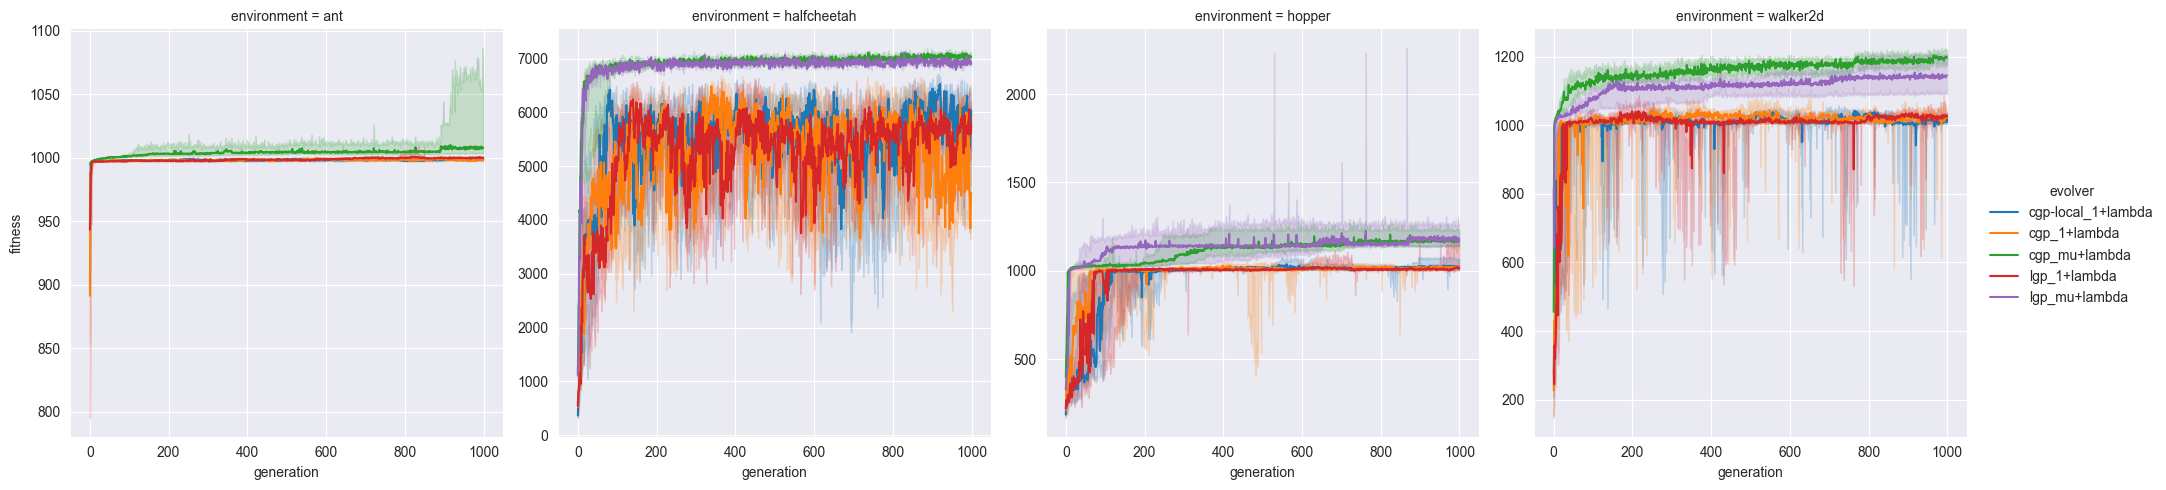

In [66]:
g = sns.relplot(
    data=df[(df["generation"] < 1000)],
    col="environment",
    kind="line",
    x="generation",
    y="top_k_fit.top_0_fit",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels("generation")
g.set_ylabels("fitness")
plt.show()

In [67]:
graph_dfs = [pd.read_csv(f"data/graph_size/{d}") for d in os.listdir("data/graph_size/")]
graph_sizes = pd.concat(graph_dfs, ignore_index=True)
graph_sizes["relative_size"] = graph_sizes["graph_size"] / graph_sizes["max_size"]
graph_sizes["evolver"] = graph_sizes["solver"] + "_" + graph_sizes["ea"]
graph_sizes = graph_sizes[[c for c in graph_sizes.columns if not c.startswith("Unnamed")]]
graph_sizes.head()

,seed,generation,graph_size,max_size,solver,ea,environment,relative_size,evolver
0,1,799,91,137,cgp-local,1+lambda,ant,0.664234,cgp-local_1+lambda
1,6,499,94,137,cgp-local,1+lambda,ant,0.686131,cgp-local_1+lambda
2,5,799,87,137,cgp-local,1+lambda,ant,0.635036,cgp-local_1+lambda
3,8,799,88,137,cgp-local,1+lambda,ant,0.642336,cgp-local_1+lambda
4,4,699,90,137,cgp-local,1+lambda,ant,0.656934,cgp-local_1+lambda


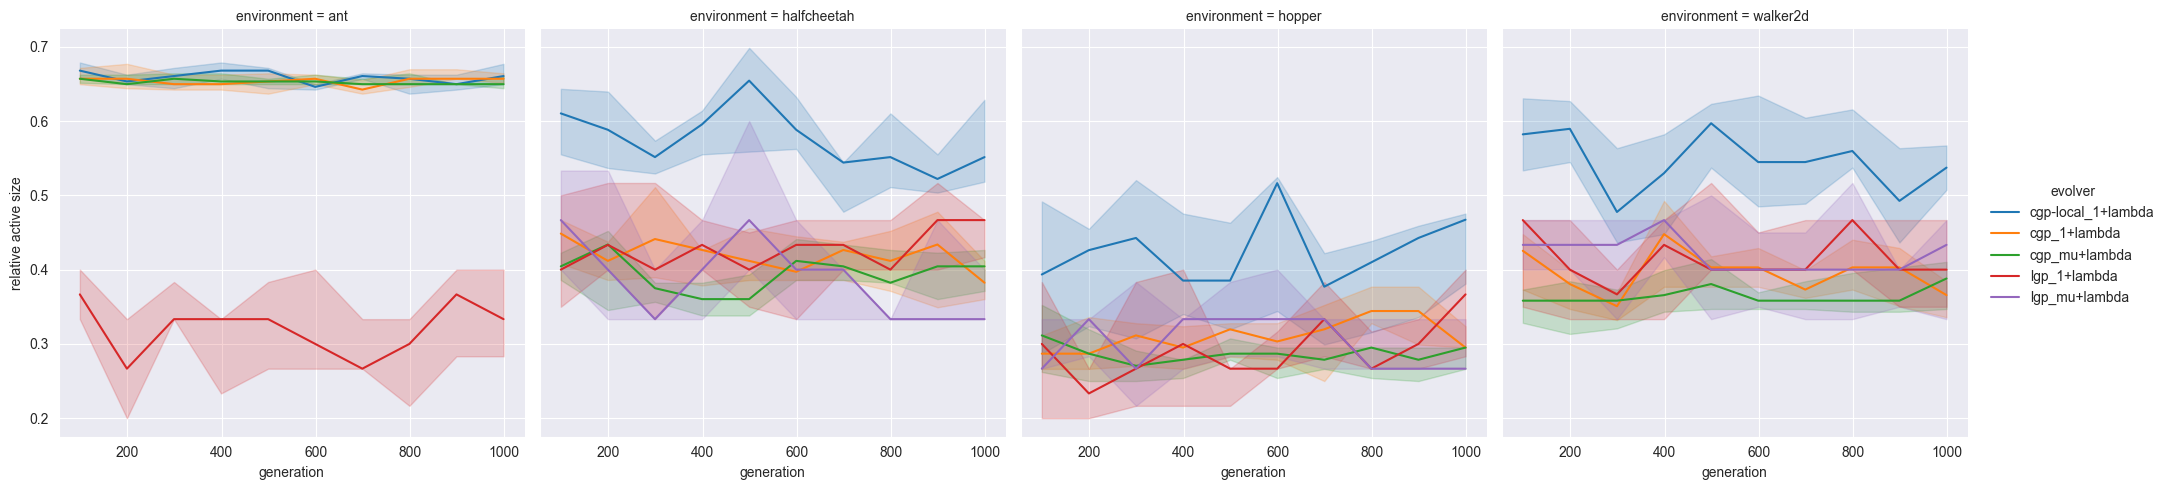

In [68]:
g = sns.relplot(
    data=graph_sizes[(graph_sizes["generation"] < 1000)],
    col="environment",
    kind="line",
    x="generation",
    y="relative_size",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50)
)
g.set_xlabels("generation")
g.set_ylabels("relative active size")
plt.show()

In [69]:
join_df = graph_sizes.merge(df, on=["solver", "generation", "environment", "seed", "evolver", "ea"])
join_df = join_df[join_df["generation"] == 999]
join_df.head()

,seed,generation,graph_size,max_size,solver,ea,environment,relative_size,evolver,_timestamp,...,evaluation_time,top_k_fit.top_0_fit,fitness_3q,fitness_mean,fitness_median,top_k_fit.top_1_fit,top_k_fit.top_2_fit,_step,_runtime,fitness_1q
13,8,999,93,137,cgp-local,1+lambda,ant,0.678832,cgp-local_1+lambda,1.687272e+09,...,4.750878,998.243530,721.634521,843.083191,924.878784,997.031860,996.737671,9998,4922.583173,996.006958
38,5,999,88,137,cgp-local,1+lambda,ant,0.642336,cgp-local_1+lambda,1.687272e+09,...,4.750878,1000.336243,710.178223,826.859802,828.441650,999.521667,980.968628,9995,4922.537123,980.696106
48,4,999,89,137,cgp-local,1+lambda,ant,0.649635,cgp-local_1+lambda,1.687272e+09,...,4.750878,997.267761,874.753662,927.909119,991.764893,996.887085,996.850647,9994,4922.522179,996.849121
62,7,999,91,137,cgp-local,1+lambda,ant,0.664234,cgp-local_1+lambda,1.687272e+09,...,4.750878,999.533569,765.611084,903.480164,993.407837,999.313232,999.041992,9997,4922.568163,998.611572
75,9,999,89,137,cgp-local,1+lambda,ant,0.649635,cgp-local_1+lambda,1.687272e+09,...,4.750878,999.321289,814.456543,889.128601,929.720581,998.952209,990.783020,9999,4922.597749,989.982300


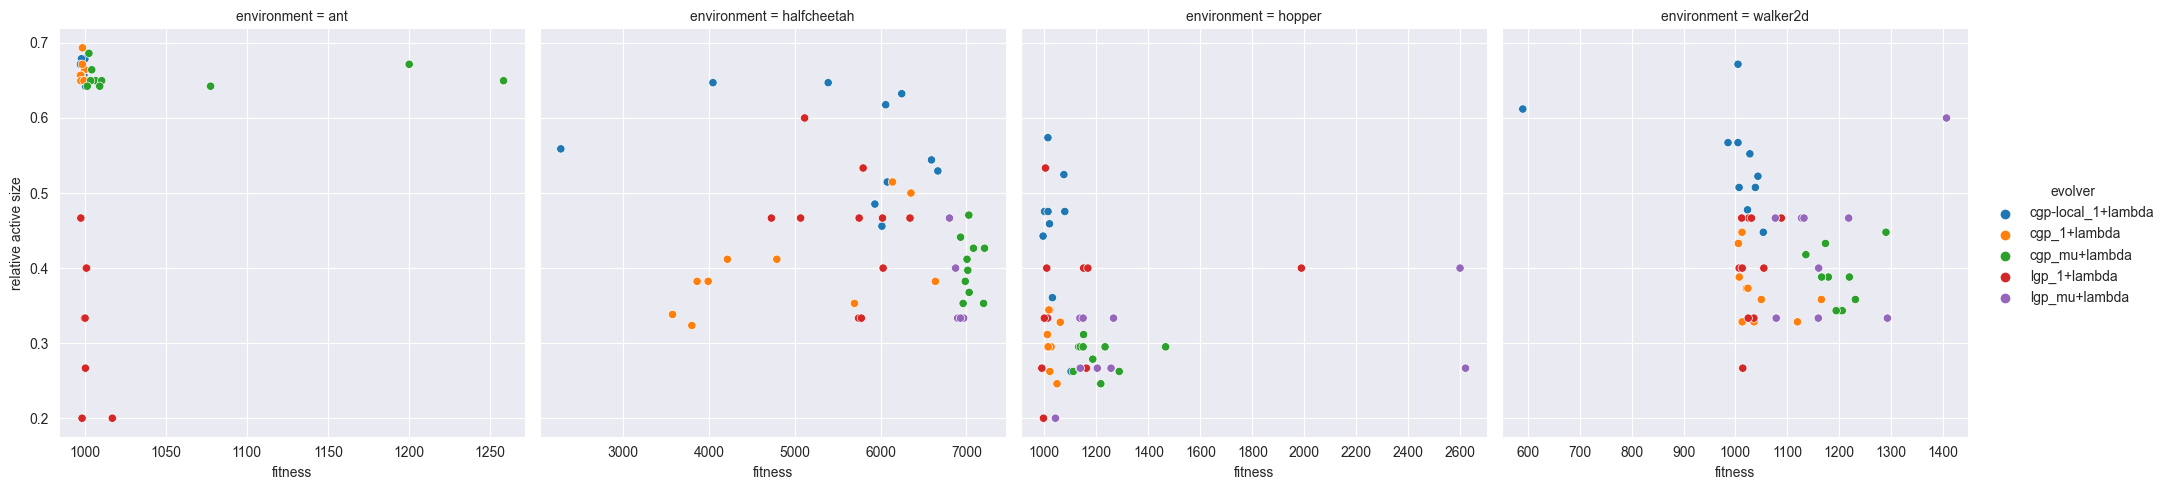

In [70]:
g = sns.relplot(
    data=join_df,
    col="environment",
    kind="scatter",
    x="top_k_fit.top_0_fit",
    y="relative_size",
    hue="evolver",
    facet_kws=dict(sharex=False)
)
g.set_xlabels("fitness")
g.set_ylabels("relative active size")
plt.show()